<center> Python implementation of Kernel Current Source Density (kCSD) method - TUTORIAL </center>
======

In [1]:
%load_ext autoreload
%autoreload 2

from ipywidgets import interact
import numpy as np
import config

import plotting_helpers as plots
from widget_helpers import dim_select, csd_select, kcsd_select, accordion, nr_ele_select, nr_broken_ele, noise_select

In [2]:
# Select dimensions of your setup

dim_select

ToggleButtons(description='Dimensions of the setup:', options=('1D', '2D', '3D'), tooltips=['Laminar probes', 'MEA like flat electrodes', 'Utah array or SEEG'], value='1D')

In [3]:
# Select a type of CSD source

csd_select


ToggleButtons(description='True source type', options=('monopole gauss', 'dipole gauss'), value='monopole gauss')

In [4]:
val = config.ValidateKCSD(dim=int(dim_select.value[0]))
csd_at, true_csd = val.generate_csd(config.csd_profile, csd_seed=5)

In [7]:
# Select number of electrodes

nr_ele_select

BoundedIntText(value=10, description='Select nr of electrodes:', max=200, min=1)

In [8]:
ele_pos, pots = val.electrode_config(config.csd_profile, csd_seed=5)

Number of electrodes: 10


In [9]:
kcsd_select

ToggleButtons(description='KCSD method', options=('ValidateKCSD1D',), value='ValidateKCSD1D')

In [14]:
print(config.kCSD)

<class 'kcsd.validation.ValidateKCSD.ValidateKCSD1D'>


In [15]:
# Call the main class with parameters of ground truth data and measurement setup

k = config.kCSD(csd_seed=5, total_ele=nr_ele_select.value,
                **config.defaults[config.kCSD.__name__])

In [16]:
obj, est_csd, est_pot = k.recon(pots, ele_pos)

No lambda given, using defaults
Cross validating R (all lambda) : 0.23
R, lambda : 0.23 4.21696503429e-17


In [10]:
# Do you want to investigate data with noise or without?

noise_select

Select(description='Noise:', options=(None, 'noise'), value=None)

In [14]:
# Estimate current source density, change value of Rs to fit the best solution using crossvalidation
# Investigate error of reconstruction

kcsd, rms, point_error = k.make_reconstruction(config.csd_profile, noise=noise_select.value, Rs=np.arange(0.2, 0.6, 0.1))

TypeError: make_reconstruction() missing 1 required positional argument: 'csd_seed'

In [ ]:
kcsd, rms, point_error = k.make_reconstruction(config.csd_profile, noise='noise', Rs=np.arange(0.2, 0.6, 0.1))

In [12]:
# Investigate spectral structure of kCSD reconstruction

structure = config.SpectralStructure(obj)

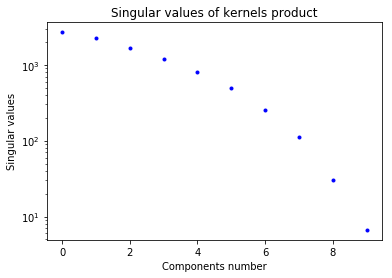

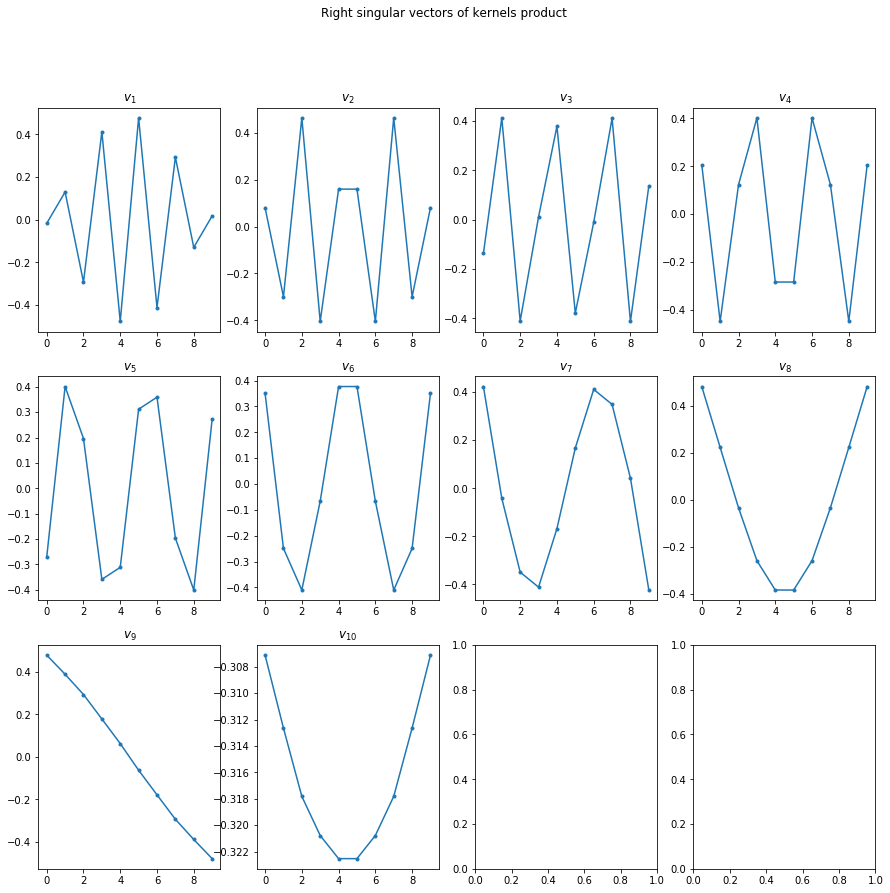

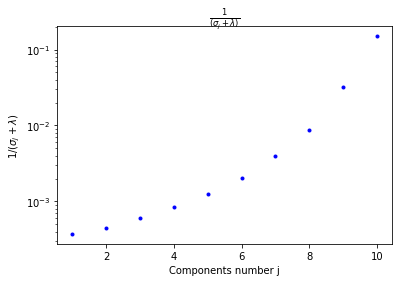

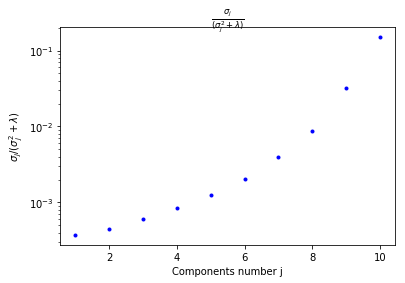

In [13]:
u_svd, sigma, v_svd = structure.svd()

Error maps
------

In [ ]:
err = config.error_map(config.csd_profile, 1, total_ele=nr_ele_select.value,
                 **config.defaults[config.kCSD.__name__])

#### Calculate errors for Error Map

It may take a few minutes.

In [ ]:
# n - number of (pseudo) random sources included in calculation of error map 

rms, point_error = err.calculate_error_map(config.csd_profile, n=50, Rs=np.arange(0.2, 0.5, 0.1))

In [ ]:
ele_pos, pots = k.electrode_config(config.csd_profile)
print(ele_pos.shape)

In [ ]:
err.plot_error_map(point_error, ele_pos)

plot results for 3D reconstruction and error maps for different layers (with slider)


use 2 subplots (left - reconstruction, right - error map for the same layer) - change it simultanously

In [ ]:
# plot results for 3D reconstruction and error maps for different layers (with slider)

# use 2 subplots (left - reconstruction, right - error map for the same layer) - change it simultanously

import plotly.plotly as py

Create error maps for setups with several broken electrodes
------

In [ ]:
# Choose how many electrodes are broken

nr_broken_ele

In [ ]:
err_broken = config.error_map(config.csd_profile, 1, total_ele=nr_ele_select.value, true_csd_xlims=[0, 1],
                              **config.defaults[config.kCSD.__name__], ele_config='broken')

In [ ]:
rms_br, point_error_br = err_broken.calculate_error_map(config.csd_profile, n=50, nr_broken_ele=nr_broken_ele.value)

In [ ]:
ele_pos_br, pots_br = err_broken.electrode_config(config.csd_profile, nr_broken_ele=nr_broken_ele.value)
print(pots.shape)

In [ ]:
err_broken.plot_error_map(point_error_br, ele_pos_br)

In [ ]:
err_broken2.plot_error_map(point_error_br2, ele_pos)

In [ ]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

In [ ]:
m_error = err_broken.sigmoid_mean(point_error)
m_error_br = err_broken.sigmoid_mean(point_error_br)
m_error_br2 = err_broken2.sigmoid_mean(point_error_br2)
plt.figure()
plt.plot(m_error, label='complete setup')
plt.plot(m_error_br, label='setup with 5 broken electrodes')
plt.plot(m_error_br2, label='setup with 7 broken electrodes')
plt.legend()